In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
games = pd.read_csv('data/games.csv')

pivoted_data = []
for fname in tqdm(glob('data/tracking_week_*.csv')):
    data = pd.read_csv(fname)

    data = pd.merge(data, games, on='gameId')
    data['is_home_team'] = (data['club'] == data['homeTeamAbbr']) + 1
    data.loc[data['club'] == 'football', 'is_home_team'] = 0
    data.sort_values(['gameId', 'playId', 'frameId', 'is_home_team'], inplace=True)
    data['player_index'] = np.arange(len(data)) % 23

    data['nflId'] = data['nflId'].fillna(0)
    data['x'] = data['x'] / 120
    data['y'] = data['y'] / 53.3
    data['dx'] = data.groupby(['gameId', 'playId', 'nflId'])['x'].diff()
    data['dy'] = data.groupby(['gameId', 'playId', 'nflId'])['y'].diff()
    data['d2x'] = data['dx'].diff()
    data['d2y'] = data['dy'].diff()

    metrics = ['x', 'y', 'dx', 'dy']

    pivoted = data.pivot_table(
        index=['gameId', 'playId', 'frameId', 'playDirection'],
        columns='player_index',
        values=metrics,
        aggfunc='first'
    )

    pivoted.columns = [f'p{col[1]}{col[0]}' for col in pivoted.columns]
    pivoted.reset_index(inplace=True)

    pivoted['playDirection'] = (pivoted['playDirection'] == 'right').astype(int)

    data['is_after_snap'] = data['frameType'].isin(['SNAP', 'AFTER_SNAP'])
    data = data[['gameId', 'playId', 'frameId', 'is_after_snap']].drop_duplicates()
    pivoted = pivoted.merge(
        data, 
        on=['gameId', 'playId', 'frameId'], 
        how='left'
    )

    pivoted_data.append(pivoted.copy())
pivoted_data = pd.concat(pivoted_data)
pivoted_data.rename(columns={'p0x': 'ballx', 'p0y': 'bally', 'p0dx': 'balldx', 'p0dy': 'balldy'}, inplace=True)
pivoted_data = pivoted_data[['gameId', 'playId', 'frameId', 'is_after_snap', 'playDirection', 'ballx', 'bally', 'balldx', 'balldy'] + [item for sublist in [[f'p{i}x', f'p{i}y', f'p{i}dx', f'p{i}dy'] for i in range(1, 23)] for item in sublist]]
pivoted_data.to_feather('data/tracking3.feather')

100%|██████████| 9/9 [01:55<00:00, 12.86s/it]


In [4]:
pivoted_data

,gameId,playId,frameId,is_after_snap,playDirection,ballx,bally,balldx,balldy,p1x,p1y,p1dx,p1dy,p2x,p2y,p2dx,p2dy,p3x,p3y,p3dx,p3dy,p4x,p4y,p4dx,p4dy,p5x,p5y,p5dx,p5dy,p6x,p6y,p6dx,p6dy,p7x,p7y,p7dx,p7dy,p8x,p8y,p8dx,p8dy,p9x,p9y,p9dx,p9dy,p10x,p10y,p10dx,p10dy,p11x,p11y,p11dx,p11dy,p12x,p12y,p12dx,p12dy,p13x,p13y,p13dx,p13dy,p14x,p14y,p14dx,p14dy,p15x,p15y,p15dx,p15dy,p16x,p16y,p16dx,p16dy,p17x,p17y,p17dx,p17dy,p18x,p18y,p18dx,p18dy,p19x,p19y,p19dx,p19dy,p20x,p20y,p20dx,p20dy,p21x,p21y,p21dx,p21dy,p22x,p22y,p22dx,p22dy
0,2022090800,56,1,False,0,0.710083,0.556098,NaN,NaN,0.745667,0.553846,NaN,NaN,0.740000,0.566417,NaN,NaN,0.759000,0.531707,NaN,NaN,0.747667,0.541651,NaN,NaN,0.754167,0.551407,NaN,NaN,0.757333,0.549906,NaN,NaN,0.763667,0.537148,NaN,NaN,0.753000,0.610507,NaN,NaN,0.743083,0.581989,NaN,NaN,0.768750,0.533208,NaN,NaN,0.749667,0.590807,NaN,NaN,0.682750,0.535084,NaN,NaN,0.690833,0.559850,NaN,NaN,0.683750,0.461351,NaN,NaN,0.680000,0.611820,NaN,NaN,0.692083,0.611632,NaN,NaN,0.698917,0.545966,NaN,NaN,0.675000,0.477298,NaN,NaN,0.687917,0.544653,NaN,NaN,0.669583,0.509944,NaN,NaN,0.666167,0.612758,NaN,NaN,0.679833,0.564728,NaN,NaN
1,2022090800,56,2,False,0,0.710083,0.556098,0.000000,0.000000,0.744917,0.553659,-0.000750,-0.000188,0.738250,0.565666,-0.001750,-0.000750,0.758833,0.527017,-0.000167,-0.004690,0.746750,0.540525,-0.000917,-0.001126,0.753750,0.547655,-0.000417,-0.003752,0.757583,0.550281,0.000250,0.000375,0.763833,0.535272,0.000167,-0.001876,0.751833,0.613508,-0.001167,0.003002,0.741667,0.582739,-0.001417,0.000750,0.769250,0.527017,0.000500,-0.006191,0.748417,0.592120,-0.001250,0.001313,0.681917,0.536398,-0.000833,0.001313,0.690417,0.560788,-0.000417,0.000938,0.683083,0.459850,-0.000667,-0.001501,0.679500,0.615197,-0.000500,0.003377,0.691917,0.613696,-0.000167,0.002064,0.699000,0.546717,0.000083,0.000750,0.674583,0.474859,-0.000417,-0.002439,0.687583,0.545028,-0.000333,0.000375,0.668500,0.508818,-0.001083,-0.001126,0.665500,0.615197,-0.000667,0.002439,0.679250,0.566229,-0.000583,0.001501
2,2022090800,56,3,False,0,0.710000,0.556098,-0.000083,0.000000,0.744000,0.553846,-0.000917,0.000188,0.736500,0.565103,-0.001750,-0.000563,0.758667,0.522326,-0.000167,-0.004690,0.745833,0.539587,-0.000917,-0.000938,0.753333,0.543902,-0.000417,-0.003752,0.757833,0.550657,0.000250,0.000375,0.763917,0.533208,0.000083,-0.002064,0.750667,0.616510,-0.001167,0.003002,0.740250,0.583490,-0.001417,0.000750,0.769750,0.520450,0.000500,-0.006567,0.746917,0.593621,-0.001500,0.001501,0.681083,0.537711,-0.000833,0.001313,0.690000,0.561914,-0.000417,0.001126,0.682417,0.458349,-0.000667,-0.001501,0.679000,0.618386,-0.000500,0.003189,0.691750,0.615760,-0.000167,0.002064,0.699000,0.547280,0.000000,0.000563,0.674250,0.472233,-0.000333,-0.002627,0.687333,0.545591,-0.000250,0.000563,0.667333,0.507505,-0.001167,-0.001313,0.664833,0.617636,-0.000667,0.002439,0.678500,0.567355,-0.000750,0.001126
3,2022090800,56,4,False,0,0.710000,0.556098,0.000000,0.000000,0.742917,0.553846,-0.001083,0.000000,0.734833,0.564353,-0.001667,-0.000750,0.758417,0.517824,-0.000250,-0.004503,0.744917,0.538837,-0.000917,-0.000750,0.752917,0.539775,-0.000417,-0.004128,0.758250,0.551407,0.000417,0.000750,0.764083,0.531332,0.000167,-0.001876,0.749500,0.619512,-0.001167,0.003002,0.738667,0.584240,-0.001583,0.000750,0.770083,0.513321,0.000333,-0.007129,0.745333,0.595497,-0.001583,0.001876,0.680167,0.538837,-0.000917,0.001126,0.689750,0.563227,-0.000250,0.001313,0.681750,0.456660,-0.000667,-0.001689,0.678417,0.621764,-0.000583,0.003377,0.691667,0.617824,-0.000083,0.002064,0.699000,0.548030,0.000000,0.000750,0.673917,0.469794,-0.000333,-0.002439,0.687250,0.546154,-0.000083,0.000563,0.666167,0.506191,-0.001167,-0.001313,0.664250,0.620075,-0.000583,0.002439,0.677750,0.568480,-0.000750,0.001126
4,2022090800,56,5,False,0,0.710000,0.556098,0.000000,0.000000,0.741667,0.553659,-0.001250,-0.000188,0.733250,0.563602,-0.001583,-0.000750,0.758083,0.513508,-0.000333,-0.004315,0.743833,0.538086,-0.001083,-0

In [5]:
pivoted_data.columns

Index(['gameId', 'playId', 'frameId', 'is_after_snap', 'playDirection',
       'ballx', 'bally', 'balldx', 'balldy', 'p1x', 'p1y', 'p1dx', 'p1dy',
       'p2x', 'p2y', 'p2dx', 'p2dy', 'p3x', 'p3y', 'p3dx', 'p3dy', 'p4x',
       'p4y', 'p4dx', 'p4dy', 'p5x', 'p5y', 'p5dx', 'p5dy', 'p6x', 'p6y',
       'p6dx', 'p6dy', 'p7x', 'p7y', 'p7dx', 'p7dy', 'p8x', 'p8y', 'p8dx',
       'p8dy', 'p9x', 'p9y', 'p9dx', 'p9dy', 'p10x', 'p10y', 'p10dx', 'p10dy',
       'p11x', 'p11y', 'p11dx', 'p11dy', 'p12x', 'p12y', 'p12dx', 'p12dy',
       'p13x', 'p13y', 'p13dx', 'p13dy', 'p14x', 'p14y', 'p14dx', 'p14dy',
       'p15x', 'p15y', 'p15dx', 'p15dy', 'p16x', 'p16y', 'p16dx', 'p16dy',
       'p17x', 'p17y', 'p17dx', 'p17dy', 'p18x', 'p18y', 'p18dx', 'p18dy',
       'p19x', 'p19y', 'p19dx', 'p19dy', 'p20x', 'p20y', 'p20dx', 'p20dy',
       'p21x', 'p21y', 'p21dx', 'p21dy', 'p22x', 'p22y', 'p22dx', 'p22dy'],
      dtype='object')

In [6]:
pivoted_data = pivoted_data[pivoted_data.is_after_snap].copy()

In [7]:
pivoted_data.p1x.value_counts()#.plot.barh()

p1x
0.593917    173
0.593417    170
0.594000    165
0.618083    161
0.592417    159
           ... 
0.982667      1
0.981250      1
0.032167      1
0.038500      1
0.047250      1
Name: count, Length: 11699, dtype: int64

In [8]:
pivoted_data.p1dx.value_counts()#.plot.barh()

p1dx
 0.000000    31416
 0.000083    14772
-0.000083    14576
-0.000167    12170
 0.000167    12026
             ...  
-0.002250        1
-0.003667        1
 0.001417        1
 0.001917        1
-0.004500        1
Name: count, Length: 1559, dtype: int64

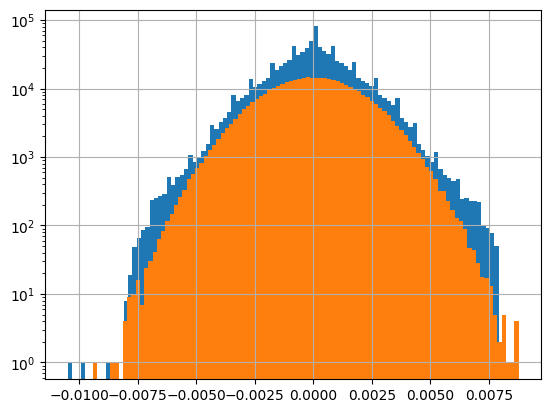

In [9]:
import matplotlib.pyplot as plt
import numpy as np
pivoted_data.p1dx.hist(bins=100)
x = np.random.normal(0, 0.002, 400000)
plt.hist(x, bins=100)
plt.yscale('log');

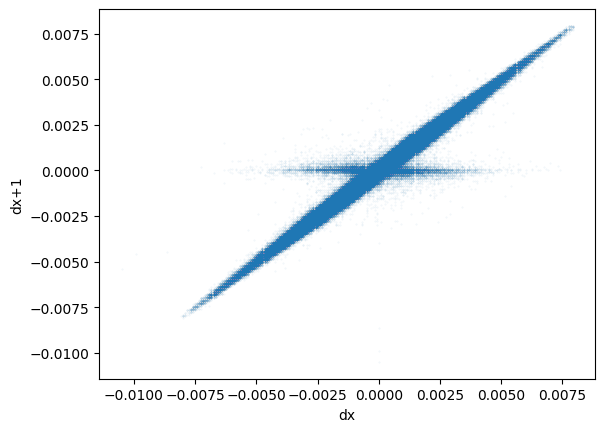

In [10]:
plt.scatter(pivoted_data.p1dx, pivoted_data.p1dx.shift(-1), s=0.1, alpha=0.1)
plt.xlabel('dx')
plt.ylabel('dx+1');

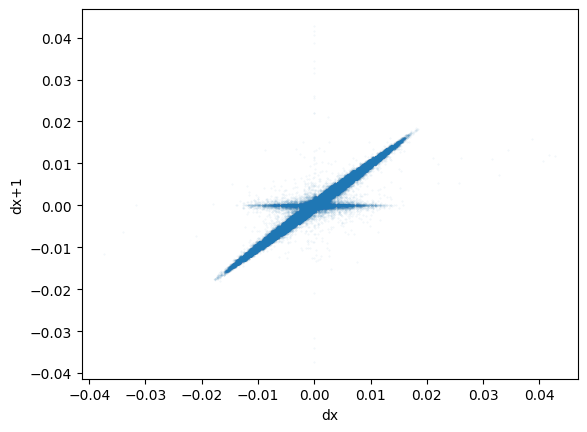

In [11]:
plt.scatter(pivoted_data.p1dy, pivoted_data.p1dy.shift(-1), s=0.1, alpha=0.1)
plt.xlabel('dx')
plt.ylabel('dx+1');